# Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# ! pip install -q transformers[sentencepiece] fastbook fastai ohmeow-blurr nbdev

In [3]:
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

In [2]:
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *

c:\Users\sanzh\Desktop\WorkSpace\Work space\Project Food Critics\myenv\lib\site-packages\blurr\text\modeling\question_answering.py:31: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric("squad")


In [5]:
doc(accuracy_multi)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd /content/drive/MyDrive/Food

/content/drive/MyDrive/Food


# Restrictions

## basic

In [ ]:
%cd /content/drive/MyDrive/Food/Restrictions

/content/drive/MyDrive/Food/Restrictions


In [13]:
df = pd.read_csv("Restrictions.csv")
df.head()

,Name,Description,Cleaned_recipe,Restriction,Body
0,Amish_Friendship_Bread_Starter,Make Amish friendship bread starter and share some with a friend! This delicious starter can make a variety of breads. Do not use metal containers or utensils.,"ounce package active dry yeast , cup warm water degrees F/ degrees C , cups all-purpose flour, divided , cups white sugar, divided , cups milk, divided","Non-vegan, dairy","Make Amish friendship bread starter and share some with a friend! This delicious starter can make a variety of breads. Do not use metal containers or utensils. ounce package active dry yeast , cup warm water degrees F/ degrees C , cups all-purpose flour, divided , cups white sugar, divided , cups milk, divided"
1,Pennsylvania_Dutch_Corn_Pie,This corn pie is my mom's recipe. We grew up eating this and loving it in the heart of Amish country. It is a very hearty dish and easy to make. Give this one a try before you decide you won't like it. Corn takes on a whole different flavor made this way. Some people add cooked chicken to the pie as well.,"large potato, peeled and chopped , ounce can whole kernel corn, drained , ounce can cream-style corn , large hard-cooked eggs, chopped , cup milk , salt and pepper to taste , tablespoon butter , -ounce double-crust pie pastry, thawed","Non-vegan, Non-Vegetarian, Non-Pescatarian, Meat, dairy","This corn pie is my mom's recipe. We grew up eating this and loving it in the heart of Amish country. It is a very hearty dish and easy to make. Give this one a try before you decide you won't like it. Corn takes on a whole different flavor made this way. Some people add cooked chicken to the pie as well. large potato, peeled and chopped , ounce can whole kernel corn, drained , ounce can cream-style corn , large hard-cooked eggs, chopped , cup milk , salt and pepper to taste , tablespoon butter , -ounce double-crust pie pastry, thawed"
2,Amish_Peanut_Butter,"This is a tasty peanut butter spread, sometimes known as 'church spread' that is common among the Amish and Mennonite communities. Great on bread, bananas, ice cream, etc.","cup light corn syrup , cup peanut butter, smooth , cup marshmallow creme","Non-vegan, Haram, Nut-allergies, dairy","This is a tasty peanut butter spread, sometimes known as 'church spread' that is common among the Amish and Mennonite communities. Great on bread, bananas, ice cream, etc. cup light corn syrup , cup peanut butter, smooth , cup marshmallow creme"
3,Amish_Meatloaf,"A recipe for Amish meatloaf topped with bacon strips and a ketchup glaze that I had while in Amish country in Holmes County, Ohio.","pounds ground beef , cups crushed butter-flavored crackers , small onion, chopped , eggs , ¾ cup ketchup , cup brown sugar , slices bacon , cup ketchup , tablespoons vinegar , ¾ teaspoon salt, or to taste , tablespoons prepared yellow mustard , cup brown sugar","Non-Vegetarian, Haram, Non-Pescatarian, pork, Meat, beaf","A recipe for Amish meatloaf topped with bacon strips and a ketchup glaze that I had while in Amish country in Holmes County, Ohio. pounds ground beef , cups crushed butter-flavored crackers , small onion, chopped , eggs , ¾ cup ketchup , cup brown sugar , slices bacon , cup ketchup , tablespoons vinegar , ¾ teaspoon salt, or to taste , tablespoons prepared yellow mustard , cup brown sugar"
4,Amish_Potato_Salad,This is like the potato salad I grew up with in Pennsylvania Dutch country. This has a sweet and sour dressing and is distinctively yellow.,"medium white potatoes with skin , small onion, finely chopped , cup chopped celery , cup chopped carrots , teaspoon celery seed , hard-cooked eggs, peeled and chopped , eggs, beaten , ¾ cup white sugar , teaspoon cornstarch , teaspoon salt , cup apple cider vinegar , cup milk , teaspoon prepared yellow mustard , tablespoons butter , cup mayonnaise or salad dressing","Non-vegan, dairy","This is like the potato salad I grew up with in Pennsylvania Dutch country. This has a sweet and sour dressing and is di

In [14]:
# Rename Origin to label
df = df.rename(columns={'Restriction': 'label'})

In [15]:
df.dropna().reset_index(drop=True)
df.shape

(4834, 5)

In [16]:
label_list = df['label'].to_list()
label_count = {}

for labels in label_list:
    label_list_split = labels.split(',')
    for label in label_list_split:
        label = label.strip()
        if label in label_count:
            label_count[label] += 1
        else:
            label_count[label] = 1

print(f"Number of labels: {len(label_count)}")
print(label_count)

Number of labels: 11
{'Non-vegan': 3944, 'dairy': 2512, 'Non-Vegetarian': 2651, 'Non-Pescatarian': 2244, 'Meat': 2463, 'Haram': 1624, 'Nut-allergies': 308, 'pork': 906, 'beaf': 788, 'alcohol': 857, 'Sea-foods': 804}


In [17]:
encode_label_type = { key: idx for idx, (key,value) in enumerate (label_count.items()) }
with open ("label_types_encode.json","w") as fp:
  json.dump(encode_label_type, fp)

In [ ]:

from collections import Counter

# Encoding label types
label_counter = Counter()
for labels in df['label']:
    label_counter.update([label.strip() for label in labels.split(',')])

encode_label_type = {label: idx for idx, (label, _) in enumerate(label_counter.items())}
with open("label_types_encoded.json", "w") as fp:
    json.dump(encode_label_type, fp)

# Convert labels to categorical format
categorical_label_list = []

label_list = df['label'].to_list()

for labels in label_list:
    categorical_list = [0] * len(encode_label_type)
    label_list_split = [label.strip() for label in labels.split(',')]
    for label in label_list_split:
        if label in encode_label_type:
            label_type_index = encode_label_type[label]
            categorical_list[label_type_index] = 1
    categorical_label_list.append(categorical_list)

df['categorical_label'] = categorical_label_list

print(encode_label_type)
print(categorical_label_list[2][:33])


{'Non-vegan': 0, 'dairy': 1, 'Non-Vegetarian': 2, 'Non-Pescatarian': 3, 'Meat': 4, 'Haram': 5, 'Nut-allergies': 6, 'pork': 7, 'beaf': 8, 'alcohol': 9, 'Sea-foods': 10}
[1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]


In [ ]:
encode_label_type

{'Non-vegan': 0,
 'dairy': 1,
 'Non-Vegetarian': 2,
 'Non-Pescatarian': 3,
 'Meat': 4,
 'Haram': 5,
 'Nut-allergies': 6,
 'pork': 7,
 'beaf': 8,
 'alcohol': 9,
 'Sea-foods': 10}

In [ ]:
df['categorical_label'] = categorical_label_list
df.tail()

,Name,Description,Cleaned_recipe,label,Body,categorical_label
4829,Chicken Pho,Mom's chicken pho recipe... straight from Vietnam. Serve with hoisin and sriracha sauce.,"quarts water , pounds chicken bones , whole chicken , medium onion , inch piece ginger , fluid ounce container chicken broth , cup rock sugar , teaspoons fish sauce , cubes pho ga soup seasoning , teaspoons salt , ounce packages rice stick noodles banh pho , pound bean sprouts , bunch green onion, chopped , bunch cilantro, chopped , sprigs Thai basil, or as needed , lime, cut in wedges","Non-vegan, Non-Vegetarian, Sea-foods, Non-Pescatarian, Meat","Mom's chicken pho recipe... straight from Vietnam. Serve with hoisin and sriracha sauce. quarts water , pounds chicken bones , whole chicken , medium onion , inch piece ginger , fluid ounce container chicken broth , cup rock sugar , teaspoons fish sauce , cubes pho ga soup seasoning , teaspoons salt , ounce packages rice stick noodles banh pho , pound bean sprouts , bunch green onion, chopped , bunch cilantro, chopped , sprigs Thai basil, or as needed , lime, cut in wedges","[1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1]"
4830,Authentic Oxtail Pho,"This oxtail pho recipe is authentic. This is the way my husband's family has always made it and it is delicious. My kids have grown up on this comforting noodle soup, which is especially good on a cold rainy day. Garnish with hoisin sauce and sriracha as desired.","water to cover , pounds beef oxtail, or to taste , Spanish onions, peeled, divided , tablespoon fish sauce, or to taste , tablespoon whole star anise pods , cinnamon stick , salt to taste , tablespoons beef pho flavor paste , bunches scallions, chopped , bunch fresh cilantro, chopped , ounce package dried rice noodles, or to taste , ounce package beef pho meatballs, halved, or to taste , pound sirloin steak, thinly sliced, or to taste , lime, cut into wedges , teaspoons white sugar, or to taste , ounce package bean sprouts , bunch Thai basil leaves, tor...","Non-vegan, Non-Vegetarian, Sea-foods, Non-Pescatarian, Meat, beaf","This oxtail pho recipe is authentic. This is the way my husband's family has always made it and it is delicious. My kids have grown up on this comforting noodle soup, which is especially good on a cold rainy day. Garnish with hoisin sauce and sriracha as desired. water to cover , pounds beef oxtail, or to taste , Spanish onions, peeled, divided , tablespoon fish sauce, or to taste , tablespoon whole star anise pods , cinnamon stick , salt to taste , tablespoons beef pho flavor paste , bunches scallions, chopped , bunch fresh cilantro, chopped , ounce package dried ric...","[1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1]"
4831,Pho Ga Soup,"Vietnamese chicken noodle soup. After ordering this soup at a local Vietnamese restaurant, I decided to try to make it at home. This is a very flexible recipe. Feel free to substitute some of your favorite vegetables or try different noodles. Enjoy!","tablespoon vegetable oil , small yellow onion, chopped , ounce package baby bella mushrooms, chopped , cloves garlic, minced , cups water , ounce package rice stick noodles such as Maifun® , teaspoons chicken bouillon , cooked chicken breasts, shredded , green onions, chopped , cup chopped fresh cilantro , cups bean sprouts , lime, sliced into wedges , dash Sriracha hot sauce, or more to taste","Non-vegan, Non-Vegetarian, Non-Pescatarian, Meat","Vietnamese chicken noodle soup. After ordering this soup at a local Vietnamese restaurant, I decided to try to make it at home. This is a very flexible recipe. Feel free to substitute some of your favorite vegetables or try different noodles. Enjoy! tablespoon vegetable oil , small yellow onion, chopped , ounce package baby bella mushrooms, chopped , cloves garlic, minced , cups water , ounce package rice stick noodles such as Maifun® , teaspoons chicken bouillon , cooked chicken breasts, shredded , green onions, chopped , cup chopped fresh cilantro , cups bean spro...","[1, 0, 1, 1, 1, 0, 0, 0,

### dataloaders and Modeling

In [12]:
labels = list(encode_label_type.keys())

NameError: name 'encode_label_type' is not defined

In [ ]:
model_name = "distilroberta-base"
model_cls= AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type= "multi_label_classification"

In [ ]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded=True, vocab=labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader('Body'), get_y=ColReader('categorical_label'), splitter=RandomSplitter(valid_pct=0.1, seed=42))

In [ ]:
dls = dblock.dataloaders(df,bs=32)
torch.save(dls,"dataloaders/dls_Restriction-classifier.pkl")

In [ ]:
dls.vocab

['Non-vegan', 'dairy', 'Non-Vegetarian', 'Non-Pescatarian', 'Meat', 'Haram', 'Nut-allergies', 'pork', 'beaf', 'alcohol', 'Sea-foods']

In [ ]:
dls.show_batch(dataloaders=dls, max_n=4, trunc_at=512)

,text,target
0,"This dish, made with chicken, kielbasa, and potatoes, takes its inspiration from the famous fish stew of the South of France and contains all the classic seasonings, including saffron. An expensive spice, saffron is essential to this dish. The best comes from Spain. I've also added a little tarragon at the end. Although not absolutely necessary, tarragon has a slight anise taste that complements the other seasonings. To reinforce its flavor, I add a splash of Pernod® or Ricard® at the last minute, although","[Non-vegan, Non-Vegetarian, Non-Pescatarian, Meat, Haram, alcohol, Sea-foods]"
1,"An antipasto is a cold platter of meat, cheese, and vegetables which is served at the start of a meal before the pasta and other courses, but to save some time, I thought we'd add the pasta right into the antipasto to turn into a complete meal all by itself. You could serve this as a side dish, but with a hunk of crusty bread and a glass of wine, I'm not sure what else you'd need. Top with more parsley before serving. ounce package fusilli pasta, clove garlic, finely crushed, anchovy fillet, table","[Meat, Haram, pork, alcohol]"
2,"This Turkish-style pizza is a Turkish flat bread layered with a fresh sauce composed of tomatoes, sweet bell peppers, and minced lamb cooked with a flavorful selection of Mediterranean spices. It is normally garnished with fresh salad and a creamy garlic sauce and or a tangy zesty hot red pepper sauce. It is a really light meal, but filling and flavorful. I find it worth the time to make if I can't get it from my favorite Turkish bakery in my old neighborhood in Amsterdam. For the best flavor, make the top","[Non-vegan, dairy, Non-Vegetarian, Non-Pescatarian, Meat]"
3,"This Turkish-style pizza is a Turkish flat bread layered with a fresh sauce composed of tomatoes, sweet bell peppers, and minced lamb cooked with a flavorful selection of Mediterranean spices. It is normally garnished with fresh salad and a creamy garlic sauce and or a tangy zesty hot red pepper sauce. It is a really light meal, but filling and flavorful. I find it worth the time to make if I can't get it from my favorite Turkish bakery in my old neighborhood in Amsterdam. For the best flavor, make the top","[Non-vegan, dairy, Non-Vegetarian, Non-Pescatarian, Meat]"


In [ ]:
model = BaseModelWrapper(hf_model)

acc_02 = partial(accuracy_multi, thresh= 0.2)

learner= Learner(dls,
                 model,
                 opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
                 loss_func=BCEWithLogitsLossFlat(),
                 metrics=[acc_02],
                 cbs=[BaseModelCallback],
                 splitter=blurr_splitter
                 ).to_fp16()

#### Stage 0

In [ ]:
learner.freeze()

SuggestedLRs(slide=0.0020892962347716093, valley=0.0002754228771664202)

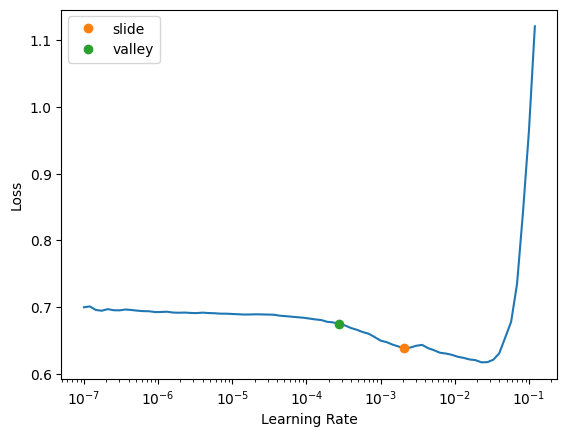

In [ ]:
learner.lr_find(suggest_funcs=(slide, valley))

In [ ]:
learner.fit_one_cycle(3, slice(1.6e-4, 2.2e-3))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.333737,0.172825,0.923395,00:25
1,0.139989,0.076092,0.966121,00:22
2,0.093537,0.068376,0.970450,00:23


In [ ]:
learner.save("restriction-classifier-stage-0")

Path('models/restriction-classifier-stage-0.pth')

In [ ]:
learner.export("models/restriction_classifier-stage-0.pkl")

#### stage-1

In [ ]:
learner.freeze()

SuggestedLRs(slide=0.002511886414140463, valley=2.2908675418875646e-06)

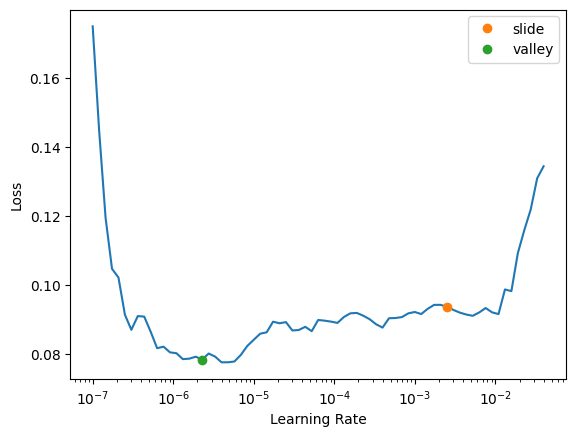

In [ ]:
learner.lr_find(suggest_funcs=(slide, valley))

In [ ]:
learner.fit_one_cycle(5, slice(2.511886414140463e-3, 2.2908675418875646e-6))


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.086425,0.063879,0.972897,00:23
1,0.078502,0.060324,0.973273,00:19
2,0.071717,0.056593,0.976661,00:18
3,0.072051,0.056075,0.975344,00:18
4,0.069418,0.055609,0.976285,00:18


In [ ]:
learner.save("restriction-classifier-stage-1")

Path('models/restriction-classifier-stage-1.pth')

In [ ]:
learner.export("models/restriction_classifier-stage-1.pkl")

#### stage 2

In [ ]:
learner.freeze()

SuggestedLRs(slide=0.005248074419796467, valley=4.365158383734524e-05)

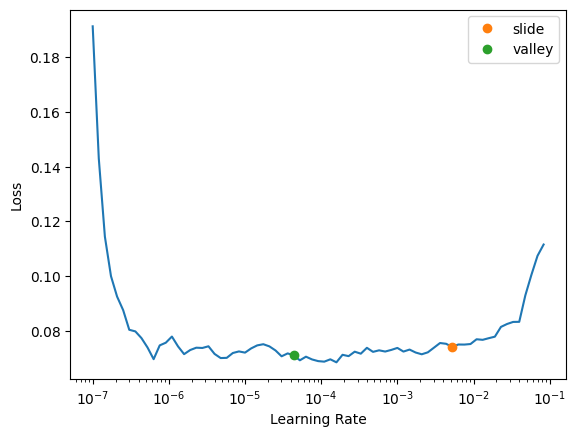

In [ ]:
learner.lr_find(suggest_funcs=(slide, valley))

In [ ]:
learner.fit_one_cycle(10, slice(5.548074419796467e-3, 4.165158383734524e-5))


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.072205,0.056419,0.975532,00:23
1,0.067639,0.054671,0.977790,00:23
2,0.069777,0.056237,0.975908,00:19
3,0.062417,0.051816,0.980425,00:18
4,0.062177,0.047227,0.979861,00:19
5,0.058195,0.047468,0.977790,00:18
6,0.057865,0.045424,0.982872,00:18
7,0.051182,0.044116,0.980614,00:18
8,0.051185,0.044482,0.980802,00:18
9,0.050753,0.044336,0.981743,00:18


In [ ]:
learner.save("restriction-classifier-stage-2")

Path('models/restriction-classifier-stage-2.pth')

In [ ]:
learner.export("models/restriction_classifier-stage-2.pkl")

## ONNX

### fastai/blurr interface

In [9]:
from tqdm.notebook import tqdm
import numpy as np

In [8]:
model_path = "models/restriction_classifier-stage-1.pkl"
learner_inf = load_learner(model_path)

In [10]:
df = pd.read_csv("Restrictions.csv")

In [18]:

from collections import Counter

# Encoding label types
label_counter = Counter()
for labels in df['label']:
    label_counter.update([label.strip() for label in labels.split(',')])

encode_label_type = {label: idx for idx, (label, _) in enumerate(label_counter.items())}
with open("label_types_encoded.json", "w") as fp:
    json.dump(encode_label_type, fp)

# Convert labels to categorical format
categorical_label_list = []

label_list = df['label'].to_list()

for labels in label_list:
    categorical_list = [0] * len(encode_label_type)
    label_list_split = [label.strip() for label in labels.split(',')]
    for label in label_list_split:
        if label in encode_label_type:
            label_type_index = encode_label_type[label]
            categorical_list[label_type_index] = 1
    categorical_label_list.append(categorical_list)

df['categorical_label'] = categorical_label_list

print(encode_label_type)
print(categorical_label_list[2][:33])


{'Non-vegan': 0, 'dairy': 1, 'Non-Vegetarian': 2, 'Non-Pescatarian': 3, 'Meat': 4, 'Haram': 5, 'Nut-allergies': 6, 'pork': 7, 'beaf': 8, 'alcohol': 9, 'Sea-foods': 10}
[1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]


In [19]:
labels = list(encode_label_type.keys())
len(labels), labels[:5]

(11, ['Non-vegan', 'dairy', 'Non-Vegetarian', 'Non-Pescatarian', 'Meat'])

In [20]:
encode_label_type

{'Non-vegan': 0,
 'dairy': 1,
 'Non-Vegetarian': 2,
 'Non-Pescatarian': 3,
 'Meat': 4,
 'Haram': 5,
 'Nut-allergies': 6,
 'pork': 7,
 'beaf': 8,
 'alcohol': 9,
 'Sea-foods': 10}

### Data splitter

In [21]:
splitter = RandomSplitter(valid_pct=0.1, seed=42)
train_ids, valid_ids = splitter(df)
len(train_ids), len(valid_ids)

(4351, 483)

In [ ]:
valid_df = df.loc[valid_ids]
valid_df.head()

Fastai/blurr interface

In [ ]:
learner_inf.model.hf_model

In [24]:
learner_inf.blurr_predict("random placeholder")

[{'labels': ['Non-vegan'],
  'scores': [0.8293439149856567],
  'class_indices': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'class_labels': ['Non-vegan', 'dairy', 'Non-Vegetarian', 'Non-Pescatarian', 'Meat', 'Haram', 'Nut-allergies', 'pork', 'beaf', 'alcohol', 'Sea-foods'],
  'probs': [0.8293439149856567,
   0.06670510768890381,
   0.10293960571289062,
   0.3060213029384613,
   0.1134425476193428,
   0.12257550656795502,
   0.02551465854048729,
   0.004377429373562336,
   0.007162883412092924,
   0.05939042568206787,
   0.0003841732395812869]}]

### Evaluation

In [25]:
from sklearn import metrics

def metric_measures(test_df, preds):

  targets = [np.asarray(target) for target in test_df['categorical_label'].to_list()]
  outputs = [np.asarray(pred) for pred in preds]


  accuracy = metrics.accuracy_score(targets, outputs)
  f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
  f1_score_macro = metrics.f1_score(targets, outputs, average='macro')

  print(f"F1 Score (Micro) = {f1_score_micro}")
  print(f"F1 Score (Macro) = {f1_score_macro}")

  return

In [26]:
preds = []
for idx, row in tqdm(valid_df.iterrows(), total=len(valid_df)):
  desc = row['Body']
  labels = learner_inf.blurr_predict(desc)[0]['labels']
  pred_genres = [0] * len(encode_label_type)
  for label in labels:
    pred_genres[encode_label_type[label]] = 1
  preds.append(pred_genres)

preds[0][:20]

  0%|          | 0/483 [00:00<?, ?it/s]

[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]

In [27]:
metric_measures(valid_df, preds)

F1 Score (Micro) = 0.9754142169962587
F1 Score (Macro) = 0.9635288349770317


### Convert to ONNX

In [28]:
model_path = "models/restriction_classifier-stage-1.pkl"
learner_inf = load_learner(model_path)

In [31]:
classifier = learner_inf.model.hf_model.eval()

torch.onnx.export(
    classifier,
    torch.LongTensor([[0] * 512]),
    'models/food-classifier.onnx',
    verbose=True,
    input_names=['input_ids'],
    output_names=['output'],
    opset_version=13,
    dynamic_axes={
        'input_ids': {0: 'batch_size', 1: 'sequence_len'},
        'output': {0: 'batch_size'}
    }
)

In [32]:
!pip install onnx onnxruntime onnxruntime-tools



  Obtaining dependency information for onnx from https://files.pythonhosted.org/packages/00/36/e7a7e7a85564e7d409e4e8addfa11d41015d2190bfff30064771e7c21ca0/onnx-1.14.1-cp310-cp310-win_amd64.whl.metadata
  Using cached onnx-1.14.1-cp310-cp310-win_amd64.whl.metadata (15 kB)
  Obtaining dependency information for onnxruntime from https://files.pythonhosted.org/packages/aa/2a/9d7edd7a329a7f34e25af60a1e47468cbc864766898c7b9d3b540d0f1539/onnxruntime-1.15.1-cp310-cp310-win_amd64.whl.metadata
  Using cached onnxruntime-1.15.1-cp310-cp310-win_amd64.whl.metadata (4.1 kB)
  Using cached onnxruntime_tools-1.7.0-py3-none-any.whl (212 kB)
  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl (46 kB)
  Obtaining dependency information for flatbuffers from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\sanzh\\Desktop\\WorkSpace\\Work space\\Project Food Critics\\myenv\\Scripts\\py3smi'
Check the permissions.



In [34]:
from onnxruntime.quantization import quantize_dynamic, QuantType

onnx_model_path = 'models/food-classifier.onnx'
quantized_onnx_model_path = 'models/food-classifier-quantized.onnx'

quantize_dynamic(
    onnx_model_path,
    quantized_onnx_model_path,
    weight_type=QuantType.QUInt8,
)

Ignore MatMul due to non constant B: /[/roberta/encoder/layer.0/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.0/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.1/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.1/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.2/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.2/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.3/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.3/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.4/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.4/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.5/attention/self/MatMul]
Ignore MatMul due to non constant

In [35]:
encode_label_type

{'Non-vegan': 0,
 'dairy': 1,
 'Non-Vegetarian': 2,
 'Non-Pescatarian': 3,
 'Meat': 4,
 'Haram': 5,
 'Nut-allergies': 6,
 'pork': 7,
 'beaf': 8,
 'alcohol': 9,
 'Sea-foods': 10}

### Normal ONNX

In [36]:
!pip install onnxruntime-gpu


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\sanzh\\Desktop\\WorkSpace\\Work space\\Project Food Critics\\myenv\\Lib\\site-packages\\onnxruntime\\capi\\onnxruntime_providers_shared.dll'
Check the permissions.




  Obtaining dependency information for onnxruntime-gpu from https://files.pythonhosted.org/packages/67/4c/03519d7dd781537083b8a0badfc15f6e334b3f7ba227a544860ded5c7157/onnxruntime_gpu-1.15.1-cp310-cp310-win_amd64.whl.metadata
   ---------------------------------------- 0.0/122.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/122.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/122.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/122.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/122.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/122.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/122.5 MB 656.4 kB/s eta 0:03:07
   ---------------------------------------- 0.1/122.5 MB 514.3 kB/s eta 0:03:58
   ---------------------------------------- 0.1/122.5 MB 514.3 kB/s eta 0:03:58
   ---------------------------------------- 0.1/122.5 MB 448.2 kB/s eta 0:04:33
   -------------------------

In [37]:
import onnxruntime as rt
from transformers import AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

class_labels = list(encode_label_type.keys())

inf_session = rt.InferenceSession('models/food-classifier.onnx',providers=['CUDAExecutionProvider'])
input_name = inf_session.get_inputs()[0].name
output_name = inf_session.get_outputs()[0].name

c:\Users\sanzh\Desktop\WorkSpace\Work space\Project Food Critics\myenv\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


In [38]:
preds = []
for idx, row in tqdm(valid_df.iterrows(), total=valid_df.shape[0]):
  desc = row['Body']
  input_ids = tokenizer(desc)['input_ids'][:512]

  probs = inf_session.run([output_name], {input_name: [input_ids]})[0]
  probs = torch.FloatTensor(probs)

  masks = torch.sigmoid(probs) >= 0.2
  labels = [class_labels[idx] for idx, mask in enumerate(masks[0]) if mask]

  pred_genres = [0] * len(encode_label_type)
  for label in labels:
    pred_genres[encode_label_type[label]] = 1
  preds.append(pred_genres)

  0%|          | 0/483 [00:00<?, ?it/s]

In [39]:
metric_measures(valid_df, preds)

F1 Score (Micro) = 0.9665271966527197
F1 Score (Macro) = 0.9462878161960467


In [40]:
encode_label_type

{'Non-vegan': 0,
 'dairy': 1,
 'Non-Vegetarian': 2,
 'Non-Pescatarian': 3,
 'Meat': 4,
 'Haram': 5,
 'Nut-allergies': 6,
 'pork': 7,
 'beaf': 8,
 'alcohol': 9,
 'Sea-foods': 10}

### Quant ONNX

In [41]:
import onnxruntime as rt
from transformers import AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

class_labels = list(encode_label_type.keys())

inf_session = rt.InferenceSession('models/food-classifier-quantized.onnx',providers=['CUDAExecutionProvider'])
input_name = inf_session.get_inputs()[0].name
output_name = inf_session.get_outputs()[0].name

c:\Users\sanzh\Desktop\WorkSpace\Work space\Project Food Critics\myenv\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


In [42]:
preds = []
for idx, row in tqdm(valid_df.iterrows(), total=valid_df.shape[0]):
  desc = row['Body']
  input_ids = tokenizer(desc)['input_ids'][:512]

  probs = inf_session.run([output_name], {input_name: [input_ids]})[0]
  probs = torch.FloatTensor(probs)

  masks = torch.sigmoid(probs) >= 0.2
  labels = [class_labels[idx] for idx, mask in enumerate(masks[0]) if mask]

  pred_genres = [0] * len(encode_label_type)
  for label in labels:
    pred_genres[encode_label_type[label]] = 1
  preds.append(pred_genres)

  0%|          | 0/483 [00:00<?, ?it/s]

In [43]:
metric_measures(valid_df, preds) #

F1 Score (Micro) = 0.9650677789363921
F1 Score (Macro) = 0.9441797649145506
